# Representational Similarity Analysis Moral Foundation Vignettes

This notebook documents the representational similiarty (RSA) analysis for moral foundation vignettes.  

It draws heavily on the [rsatoolbox](https://rsatoolbox.readthedocs.io/en/latest/) developed by Niko Kriegeskorte and colleagues. 

In [1]:
%matplotlib inline

import os
from joblib import Parallel, delayed
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from scipy import stats
from sklearn.manifold import MDS, TSNE

import rsatoolbox
import rsatoolbox.data as rsd
import rsatoolbox.rdm as rsr
from rsatoolbox.rdm import RDMs as rdm
from rsatoolbox.rdm import get_categorical_rdm

from rsa_utils import get_beh_sim, conditions, all_conditions, item_order, tick_labels, vig_cmap

/usr/local/miniconda3/envs/naturalistic/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


***

# Candidate Models

We first create all candidate models that will be used to predict the representations in neural reference models.

## Categorical Models

In [2]:
# Define condition labels for RDM Models
labels = ['Physical Care', 'Emotional Care', 'Fairness', 'Liberty', 'Loyalty', 'Authority', 'Sanctity', 'Social Norms']

cond_names_long = []
for ix, name in enumerate(labels):
    for i in range(0,15):
        cond_names_long.append(f'{"{0:0>3}".format(ix)}_{name}')
        
cond_names_short = []
for ix, name in enumerate(labels):
    cond_names_short.append(f'{"{0:0>3}".format(ix)}_{name}')

In [3]:
# Create categorical models
## Independent Model
independent = [str(x) for x in range(0,8)]
rdm_independent = get_categorical_rdm(independent)
 
## Ind:Bind > Social Model
ind_bind_moral_socn = pd.DataFrame(index=labels, columns=labels, data=0.0)
for i,row in ind_bind_moral_socn.iterrows():
    if i.startswith("Social"):
        for col,ix in row.iteritems():
            ind_bind_moral_socn.at[i,col] = 1
            ind_bind_moral_socn.at[col,i] = 1
    else:
        for col,ix in row.iteritems():
            ind_bind_moral_socn.at[i,col] = 0
            ind_bind_moral_socn.at[col,i] = 0      

for i,row in ind_bind_moral_socn.iterrows():
    for col in ind_bind_moral_socn.columns:
        if i.startswith("Social") and col.startswith('Social'):
                ind_bind_moral_socn.at[i,col] = 0
                ind_bind_moral_socn.at[col,i] = 0
                
ind_cols = ['Physical Care', 'Emotional Care','Fairness', 'Liberty']
bind_cols = ['Loyalty', 'Authority','Sanctity']

for i,row in ind_bind_moral_socn.iterrows():
    for col in ind_bind_moral_socn.columns:
        for ind in ind_cols:
            for bind in bind_cols:
                if i.startswith(ind) and col.startswith(bind):
                        ind_bind_moral_socn.at[i,col] = 0.3
                        ind_bind_moral_socn.at[col,i] = 0.3
                
ind_bind_moral_socn = ind_bind_moral_socn.to_numpy()
ind_bind_moral_socn[np.diag_indices(len(labels))] = 0
rdm_ind_bind_moral_socn = Adjacency(ind_bind_moral_socn, matrix_type='distance', labels=labels)
rdm_ind_bind_moral_socn = rdm(rdm_ind_bind_moral_socn.data.reshape(1, 28))

## Ind > Bind > Social Model    
ind_bind_social = []
for x in range(0,4):
    ind_bind_social.append(str(0))
for x in range(0,3):
    ind_bind_social.append(str(1))
for x in range(0,1):
    ind_bind_social.append(str(2))
rdms_model_ind_bind_social = get_categorical_rdm(ind_bind_social)

## Moral > Social Model
moral_social =  list((np.repeat('Moral', 7))) + list((np.repeat('Social', 1)))
rdms_model_moral_social = get_categorical_rdm(moral_social)

In [4]:
# Concat Categorical RDMs
model_rdms = rdm_independent
model_rdms.append(rdms_model_ind_bind_social)
model_rdms.append(rdm_ind_bind_moral_socn)
model_rdms.append(rdms_model_moral_social)

model_names = ['Independent', 'Ind/Bind/Social', 'Ind:Bind/Social', 'Moral/Social']
model_rdms.rdm_descriptors['model_names'] = model_names
model_rdms.pattern_descriptors['cond_names'] = labels

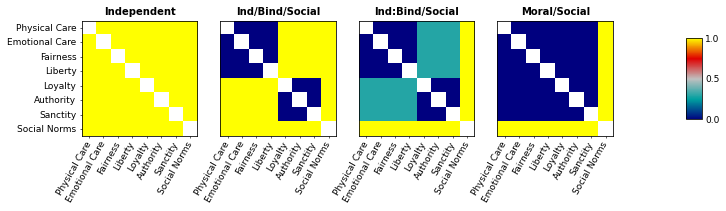

In [5]:
# Visualize Categorical RDMs
fig, ax, ret_val = rsatoolbox.vis.show_rdm(model_rdms, rdm_descriptor='model_names', n_row=1, 
                                          figsize=(12,6), pattern_descriptor='cond_names', show_colorbar='figure')
# plt.savefig('plots/rdm_models.png', dpi=300, bbox_inches='tight')

***

# Moral Judgment Model

Loads the moral wrongness ratings for each participant and vignette item and constructs an RDM. 

In [6]:
# Load and Parse Moral Judgment Ratings
exp_dir = '../../../bids'

vig_beh_files = glob.glob(os.path.join(exp_dir, 'sub-*/beh/sub-*_task-vignette_*_beh.tsv'))
vig_beh_dfs = []
for file in vig_beh_files:
    df = pd.read_csv(file, sep='\t')
    df['run'] = int(file.split('/')[-1].split('-')[-1].split('_')[0])
    vig_beh_dfs.append(df)
vig_beh = pd.concat(vig_beh_dfs)
vig_beh['item'] = vig_beh['stim_file'].apply(lambda x: x.split('/')[-1].split('.')[0])
vig_beh = vig_beh.reset_index()[['sub_id','item','trial_type','run','moral_decision','RT']].sort_values("sub_id")

In [7]:
def parse_beh(sub):
    sub_data = vig_beh[vig_beh['sub_id']==sub][['item','trial_type','moral_decision','run']]
    # Impute missing values with condition median
    cond_medians = sub_data.groupby('trial_type')['moral_decision'].median()
    for cond, median in cond_medians.iteritems():
        mask = sub_data[sub_data['trial_type']==cond].index
        sub_data.loc[mask, 'moral_decision'] = sub_data.loc[mask, 'moral_decision'].fillna(median)
     
    by_run = sub_data.groupby(['run','trial_type']).mean()
    
    
    r1 = by_run.loc[1].loc[['carep','carem','fair','lib','loy','auth','pur','socn']]
    r2 = by_run.loc[2].loc[['carep','carem','fair','lib','loy','auth','pur','socn']]
    r3 = by_run.loc[3].loc[['carep','carem','fair','lib','loy','auth','pur','socn']]
    runs_data = pd.concat([r1,r2,r3])
    runs = np.concatenate( (np.repeat(1, 8), np.repeat(2, 8), np.repeat(3, 8)) )
    
    
    return runs, pd.DataFrame(runs_data['moral_decision']).to_numpy()

In [9]:
sub_list = ["sub-" + "{0:0>2}".format(x) for x in range(1,65)]

data_list = []
for sub in sub_list:
    if sub == 'sub-35':
        continue
    runs, measurements = parse_beh(sub)
    conds = np.tile(cond_names_short, 3)
    obs_des = {'conds': conds, 'sessions':runs}

    data = rsd.Dataset(measurements=measurements,
                       obs_descriptors=obs_des)
    
    data_list.append(data)
    
rdms_moral_judg = rsatoolbox.rdm.calc_rdm(data_list, method='crossnobis', descriptor='conds', cv_descriptor='sessions')
rdms_moral_judg.save('rdms/moral_judg.hdf5', overwrite=True)
rdms_moral_judg_mean = rdms_moral_judg.mean()
rdms_moral_judg_mean.pattern_descriptors['cond_names'] = labels
rdms_moral_judg_mean.rdm_descriptors['model_names'] = ['Moral Judgment']

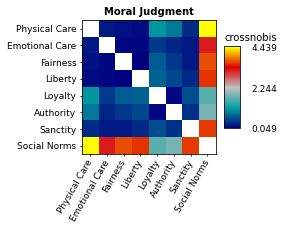

In [46]:
fig, ax, ret_val = rsatoolbox.vis.show_rdm(rdms_moral_judg_mean, n_row=1, show_colorbar='panel',
                                          figsize=(3,6), rdm_descriptor='Moral Judgment', pattern_descriptor='cond_names')
# plt.savefig('plots/rdm_jg.png', dpi=300, bbox_inches='tight')

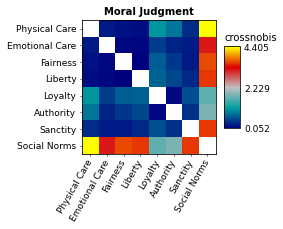

In [10]:
fig, ax, ret_val = rsatoolbox.vis.show_rdm(rdms_moral_judg_mean, n_row=1, show_colorbar='panel',
                                          figsize=(3,6), rdm_descriptor='Moral Judgment', pattern_descriptor='cond_names')
# plt.savefig('plots/rdm_jg.png', dpi=300, bbox_inches='tight')

# Response Time Model

Loads the response times for each participant and vignette item and constructs an RDM. 

In [13]:
def parse_rt(sub):
    sub_data = vig_beh[vig_beh['sub_id']==sub][['item', 'trial_type','RT','run']]
    # Impute missing values with condition median
    cond_medians = sub_data.groupby('trial_type')['RT'].median()
    for cond, median in cond_medians.iteritems():
        mask = sub_data[sub_data['trial_type']==cond].index
        sub_data.loc[mask, 'RT'] = sub_data.loc[mask, 'RT'].fillna(median)
    by_run = sub_data.groupby(['run','trial_type']).mean()
    
    r1 = by_run.loc[1].loc[['carep','carem','fair','lib','loy','auth','pur','socn']]
    r2 = by_run.loc[2].loc[['carep','carem','fair','lib','loy','auth','pur','socn']]
    r3 = by_run.loc[3].loc[['carep','carem','fair','lib','loy','auth','pur','socn']]
    runs_data = pd.concat([r1,r2,r3])
    runs = np.concatenate( (np.repeat(1, 8), np.repeat(2, 8), np.repeat(3, 8)) )

    return runs, pd.DataFrame(runs_data['RT']).to_numpy()

In [15]:
data_list = []
for sub in sub_list:
    if sub == 'sub-35':
        continue
    runs, measurements = parse_rt(sub)
    conds = conds = np.tile(cond_names_short, 3)
    obs_des = {'conds': conds, 'sessions':runs}

    data = rsd.Dataset(measurements=measurements,
                       obs_descriptors=obs_des)
    
    data_list.append(data)
    
rdms_moral_rt = rsatoolbox.rdm.calc_rdm(data_list, method='crossnobis', descriptor='conds', cv_descriptor='sessions')
rdms_moral_rt.save('rdms/moral_rt.hdf5', overwrite=True)
rdms_moral_rt_mean = rdms_moral_rt.mean()
rdms_moral_rt_mean.pattern_descriptors['cond_names'] = labels
rdms_moral_rt_mean.rdm_descriptors['model_names'] = ['Response Time']

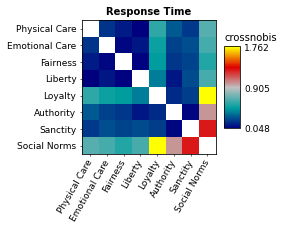

In [16]:
fig, ax, ret_val = rsatoolbox.vis.show_rdm(rdms_moral_rt_mean, n_row=1, show_colorbar='panel',
                                          figsize=(3,6), rdm_descriptor='Response Time', pattern_descriptor='cond_names')
# plt.savefig('plots/rdm_jg.png', dpi=300, bbox_inches='tight')

***

# Reference Models

In the next steps, we construct the neural reference RDMs based on beta estimates for each vignette item and participant (see file single-trial_glm.py for GLM details). 

In [13]:
# Load Brain Mask to select morally-relevant ROIS
from nltools.data import Brain_Data
from nltools.mask import expand_mask, collapse_mask

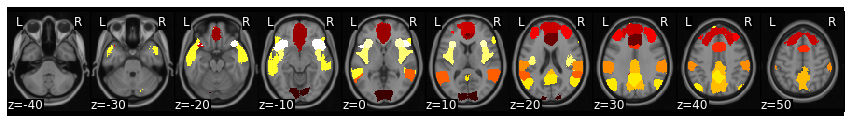

In [14]:
# brain_mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
brain_mask = Brain_Data('k50_2mm.nii.gz')
brain_mask_x = expand_mask(brain_mask)

moral_rois = {
            4:'V1', 
            0:'amPFC',
            32:'vmPFC',
            2:'dmPFC',
            44:'dlPFC',
            22:'dACC',
            5:'TPJ/Ang. Gyrus',
            15:'TPJ/Par. Operculum',
            6:'PCC/Precuneus',
            19:'PCC/Superior LOC',
            49:'STS',
            16:'mInsula',
            18:'daInsula',
            37:'vaInsula'
}

moral_rois_mask = collapse_mask(brain_mask_x[list(moral_rois.keys())])
moral_rois_mask_x = expand_mask(moral_rois_mask)
moral_rois_mask.plot()

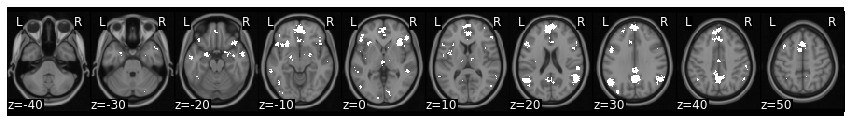

In [15]:
neurosynth_moral = Brain_Data('../mvpa/masks/moral_uniformity-test_z_FDR_0.01.nii.gz').threshold(1, binarize=True)
neurosynth_moral.plot()

In [16]:
def get_vig_run(sub):
    return vig_beh[vig_beh['sub_id']==sub][['item','run','trial_type']].set_index('item').loc[item_order]

def parse_brain(sub):
    vig_runs = get_vig_run(sub)
    
    beta_files = {1:{x:[] for x in vig_runs.trial_type.unique()},
                  2:{x:[] for x in vig_runs.trial_type.unique()},
                  3:{x:[] for x in vig_runs.trial_type.unique()}}
    
    for item,row in vig_runs.iterrows():
        beta_files[row['run']][row['trial_type']].append( glob.glob(f'betas/{sub}_{item}*')[0] )
    
    betas_brain = Brain_Data()
    for run,cond_dict in beta_files.items():
        for cond, items in cond_dict.items():
            betas_brain = betas_brain.append(Brain_Data(items).mean().standardize(axis=0, method='center'))
    
    runs = np.concatenate( (np.repeat(1, 8), np.repeat(2, 8), np.repeat(3, 8)) )
    conds = np.tile(cond_names_short, 3)
    obs_des = {'conds': conds, 'sessions': runs}
             
    sub_datasets = {}
    for roi_ix in enumerate(moral_rois.keys()):
        betas_masked = betas_brain.apply_mask(moral_rois_mask_x[roi_ix[0]]).data
        data = rsd.Dataset(measurements=betas_masked,
                       obs_descriptors=obs_des)
        sub_datasets[roi_ix] = data
   
    moral_brain = betas_brain.apply_mask(neurosynth_moral).data
    data = rsd.Dataset(measurements=moral_brain,
                       obs_descriptors=obs_des)
    sub_datasets['Neurosynth Moral'] = data
    
    return sub_datasets

In [17]:
sub_list.remove('sub-35')

In [18]:
sub_data_list = Parallel(n_jobs=20)(delayed(parse_brain)(sub) for sub in sub_list)

In [19]:
brain_measures = {v:[] for v in moral_rois.values()}
for roi_ix, (k,v) in enumerate(moral_rois.items()):
    for sub in sub_data_list:
        brain_measures[v].append(sub[(roi_ix,k)])
        
brain_measures['Neurosynth Moral'] = []
        
for sub in sub_data_list:
    brain_measures['Neurosynth Moral'].append(sub['Neurosynth Moral'])

In [20]:
roi_rdms = {x:None for x in brain_measures.keys()}

for roi, datalist in brain_measures.items():
    print(roi)
    rdms = []
    for sub in datalist:
        sub_rdm = rsr.calc_rdm(sub, method='crossnobis', descriptor='conds', cv_descriptor='sessions')
        rdms.append(sub_rdm)
    roi_rdms[roi] = rsatoolbox.rdm.RDMs( np.concatenate( [x.get_matrices() for x in rdms], axis=0) )

V1
amPFC
vmPFC
dmPFC
dlPFC
dACC
TPJ/Ang. Gyrus
TPJ/Par. Operculum
PCC/Precuneus
PCC/Superior LOC
STS
mInsula
daInsula
vaInsula
Neurosynth Moral


In [21]:
roi_rdms_means = []
for roi, datalist in roi_rdms.items():
    roi_rdms_means.append(datalist.mean())

roi_rdms_means = rsatoolbox.rdm.RDMs( np.concatenate( [x.get_matrices() for x in roi_rdms_means], axis=0) )
    
model_names = [x for x in moral_rois.values()]
model_names.append('Neurosynth Moral')
roi_rdms_means.rdm_descriptors['model_names'] = model_names
roi_rdms_means.pattern_descriptors['cond_names'] = labels

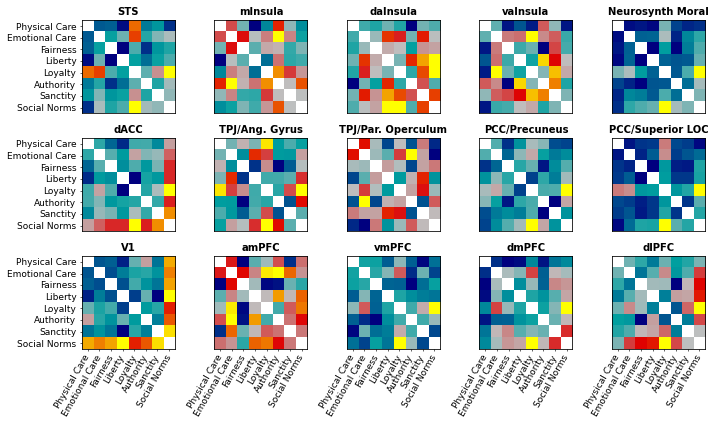

In [22]:
fig, ax, ret_val = rsatoolbox.vis.show_rdm(roi_rdms_means, rdm_descriptor='model_names',
                                          figsize=(10,6), n_row=3, pattern_descriptor='cond_names', 
                                           )
plt.tight_layout()
plt.savefig('plots/reference_rdms.png', dpi=300, bbox_inches='tight')

***

# RDM Relationships

Compute whitened cosine similarity between all RDMs

In [51]:
model_names = ['Independent', 
               'Ind/Bind/Social', 'Ind:Bind/Social', 
          'Moral/Social']+['Moral Judgment','Response Time']+[x for x in roi_rdms_means.rdm_descriptors['model_names']]

In [52]:
cosines = pd.DataFrame(columns=model_names,
                       index=model_names)

In [53]:
models = [model_rdms,
          rdms_moral_judg_mean,
          rdms_moral_rt_mean,
          roi_rdms_means]

In [54]:
# Start to loop over rdm_models to get pairs
for rdms_a in models:
    for rdms_b in models:
        # Is there more than one RDM in the current model?
        if len(rdms_a.rdm_descriptors['model_names']) > 1:
            for rdm_a in rdms_a:
                # Start same check for rdms_b
                if len(rdms_b.rdm_descriptors['model_names']) > 1:
                    for rdm_b in rdms_b:
                        # Check we dont eval. the same model
                        name_a = rdm_a.rdm_descriptors['model_names'][0]
                        name_b = rdm_b.rdm_descriptors['model_names'][0]
                        if name_a != name_b:
                            rho = rsatoolbox.rdm.compare_cosine_cov_weighted(rdm_a, rdm_b)
                            cosines.at[name_a, name_b] = float(rho[0])
                            cosines.at[name_b, name_a] = float(rho[0])
                else:
                    name_a = rdm_a.rdm_descriptors['model_names'][0]
                    name_b = rdms_b.rdm_descriptors['model_names'][0]
                    if name_a != name_b:
                        rho = rsatoolbox.rdm.compare_cosine_cov_weighted(rdm_a, rdms_b)
                        cosines.at[name_a, name_b] = float(rho[0])
                        cosines.at[name_b, name_a] = float(rho[0])
                    
                                   
        else:
            if len(rdms_b.rdm_descriptors['model_names']) == 1:
                name_a = rdms_a.rdm_descriptors['model_names'][0]
                name_b = rdms_b.rdm_descriptors['model_names'][0]
                if name_a != name_b:
                    rho = rsatoolbox.rdm.compare_cosine_cov_weighted(rdms_a, rdms_b)
                    cosines.at[name_a, name_b] = float(rho[0])
                    cosines.at[name_b, name_a] = float(rho[0])

In [55]:
plt.style.use('seaborn-poster')

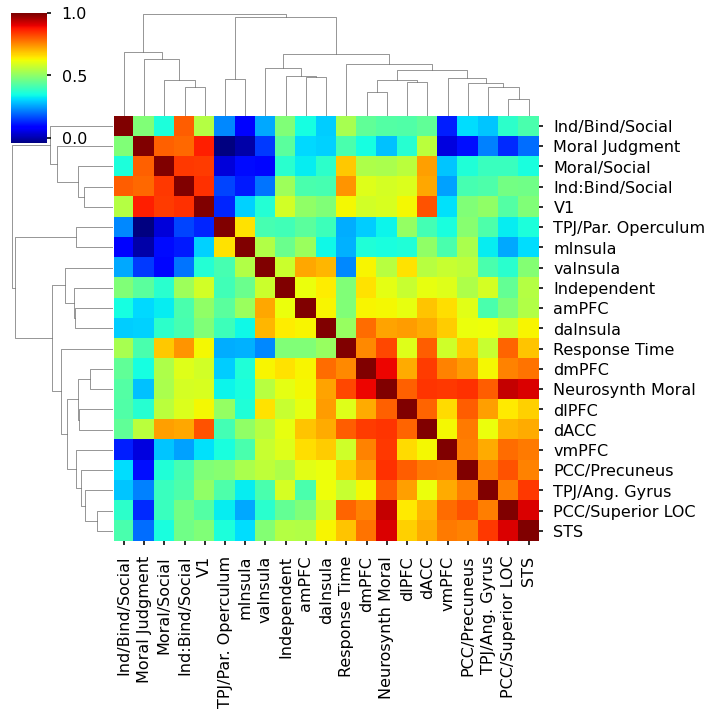

In [56]:
sns.clustermap(cosines.fillna(1), cmap="jet")
plt.savefig('plots/clustermap.png', dpi=300)

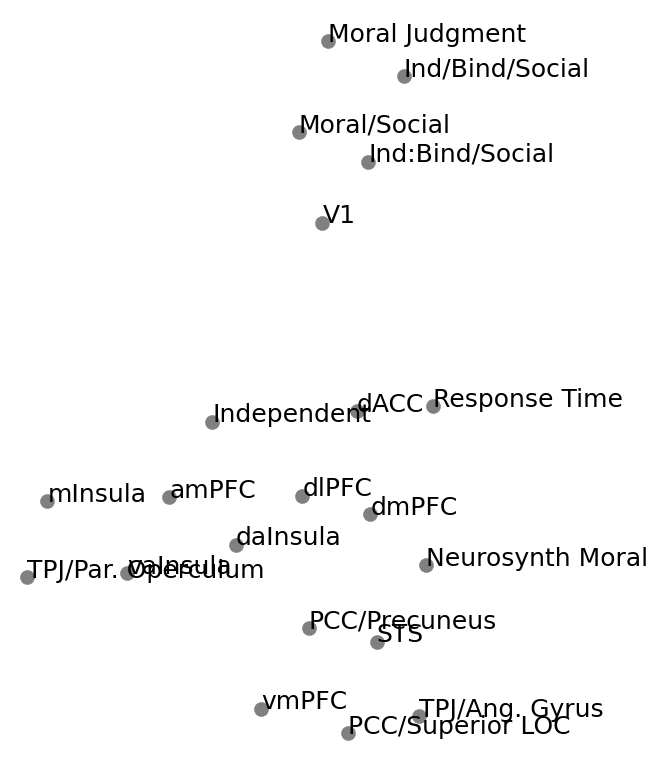

In [57]:
clf = TSNE(perplexity=10.0)
clf.fit(cosines.fillna(1))
dist_mds = clf.fit_transform(cosines.fillna(1))

x = dist_mds[:, 0]
y = dist_mds[:, 1]

fig, ax = plt.subplots(figsize=(8,14))
plt.scatter( x, y , c='grey', s=200)
for i in range(len(model_names)):
    plt.annotate( model_names[i],
                  xy = ( x[i], y[i] ),
                  xytext = ( x[i], y[i] ),
                  c='black', fontsize=25)

plt.axis("off")
plt.savefig("plots/mds_rdms.png", dpi=200, bbox_inches='tight')
plt.show()

***

# Model Inference

In [59]:
fx_models = []
for rdm in model_rdms:
    name = rdm.rdm_descriptors['model_names'][0]
    m = rsatoolbox.model.ModelFixed(name, rdm)
    fx_models.append(m)
    
name = rdms_moral_judg_mean.rdm_descriptors['model_names'][0]
m = rsatoolbox.model.ModelFixed(name, rdms_moral_judg_mean)
fx_models.append(m)

name = rdms_moral_rt_mean.rdm_descriptors['model_names'][0]
m = rsatoolbox.model.ModelFixed(name, rdms_moral_rt_mean)
fx_models.append(m)

In [60]:
print('created the following models:')
for i in range(len(fx_models)):
    print(fx_models[i].name)

created the following models:
Independent
Ind/Bind/Social
Ind:Bind/Social
Moral/Social
Moral Judgment
Response Time


In [61]:
def rsa_inf(roi, brain_rdms):
    models = rsatoolbox.inference.eval_bootstrap_rdm(fx_models, brain_rdms, method='cosine_cov', N=2000)
    return (roi, models)

In [62]:
model_comp = Parallel(n_jobs=12)(delayed(rsa_inf)(roi, brain_rdm) for (roi, brain_rdm) in roi_rdms.items())

In [63]:
results = []
for roi_model in model_comp:
    roi = roi_model[0]
    model = roi_model[1]
    data=pd.DataFrame(model.evaluations).melt()
    data['ROI'] = roi
    results.append(data)
results = pd.concat(results)

In [64]:
plt.style.use('seaborn-poster')

In [65]:
sns.set_style('white')

In [66]:
from matplotlib import patches

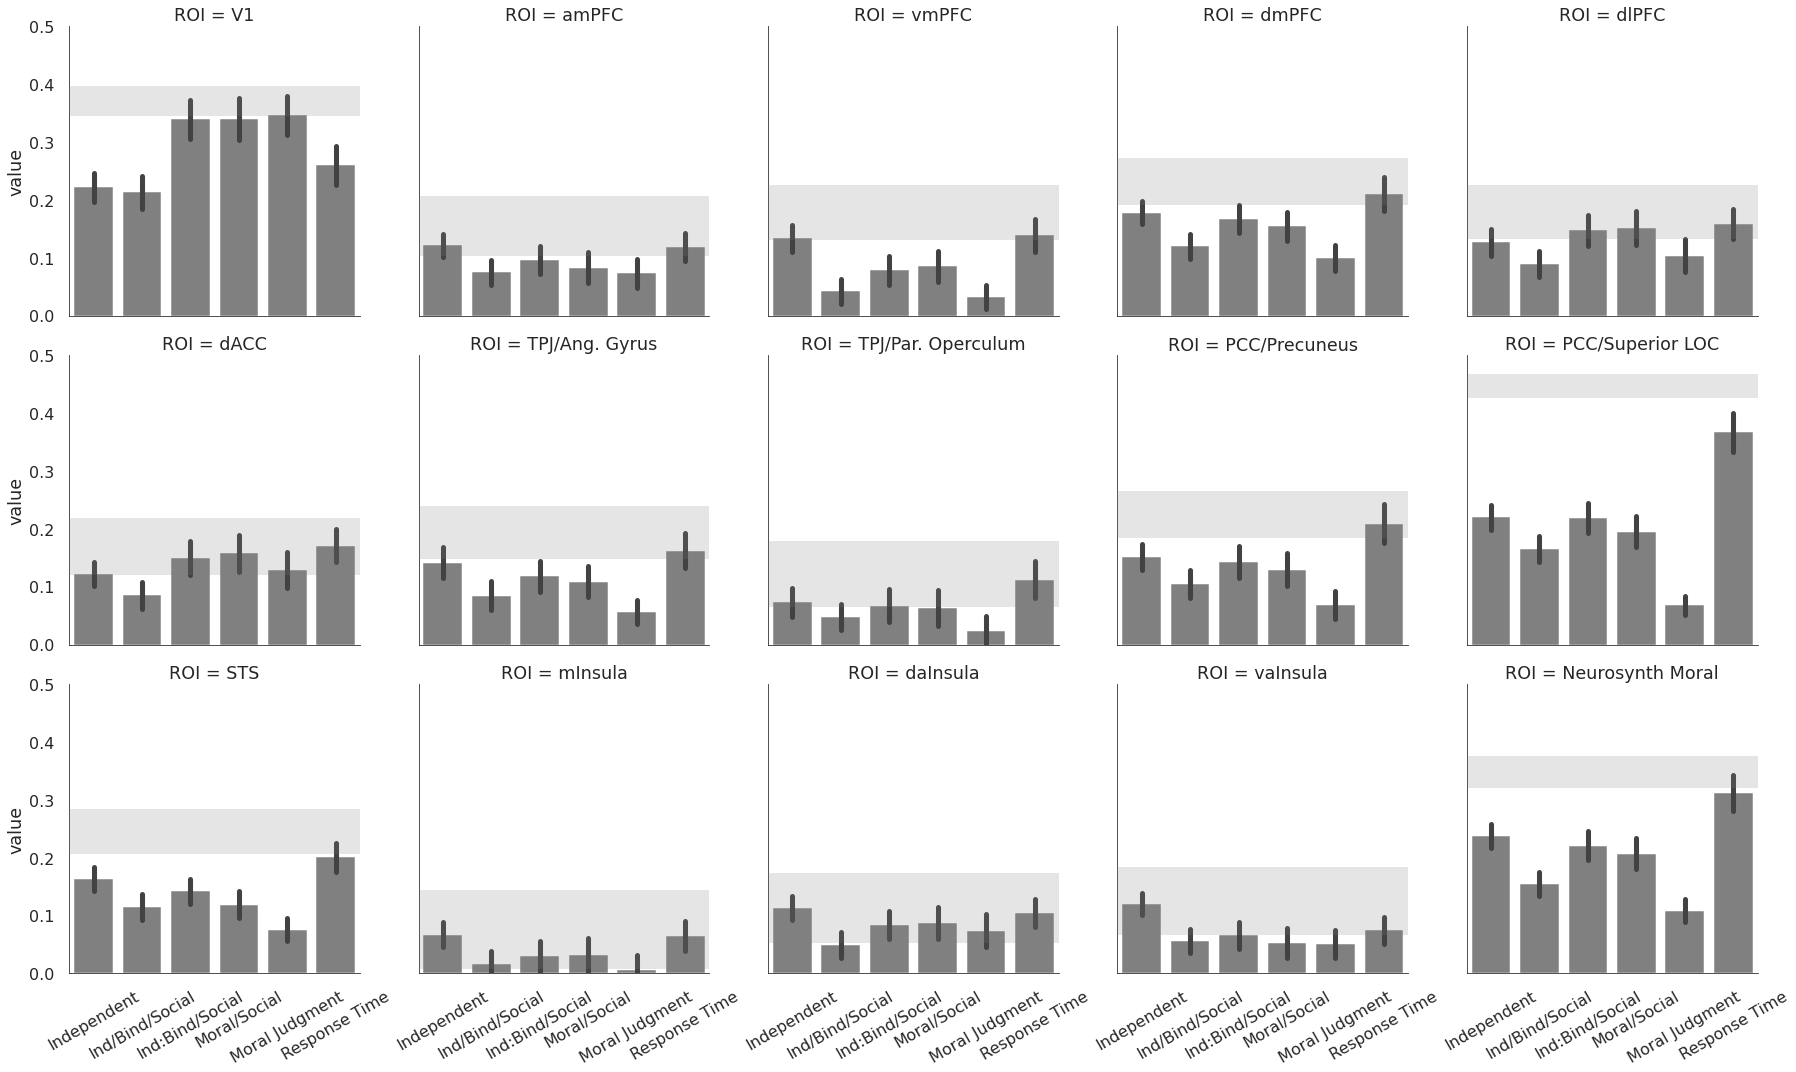

In [68]:
noise_ceil_col = [0.5, 0.5, 0.5, 0.2]
# fig, ax = plt.subplots(figsize=(4,4))
f = sns.catplot(x='variable', y='value', col='ROI', data=results, ci='sd', kind='bar',col_wrap=5,
              legend=True, aspect=1, color='grey')

for ix, (k,v) in enumerate(model_comp): 
    noise_lower = np.nanmean(v.noise_ceiling[0])
    noise_upper = np.nanmean(v.noise_ceiling[1])
    noiserect = patches.Rectangle((-0.5, noise_lower), len(model_names[0:6]),
                                      noise_upper-noise_lower, linewidth=0,
                                      facecolor=noise_ceil_col, zorder=1e6)
    f.axes[ix].add_patch(noiserect)
    
    f.axes[ix].set_xlabel('');
    f.axes[ix].set_xticklabels(model_names[0:6], rotation=30);
    
sns.despine()
plt.ylim(0,0.5)
plt.tight_layout()
plt.savefig('plots/model_comp.png', dpi=500)

V1
amPFC
vmPFC
dmPFC
dlPFC
dACC
TPJ/Ang. Gyrus
TPJ/Par. Operculum
PCC/Precuneus
PCC/Superior LOC
STS
mInsula
daInsula
vaInsula
Neurosynth Moral


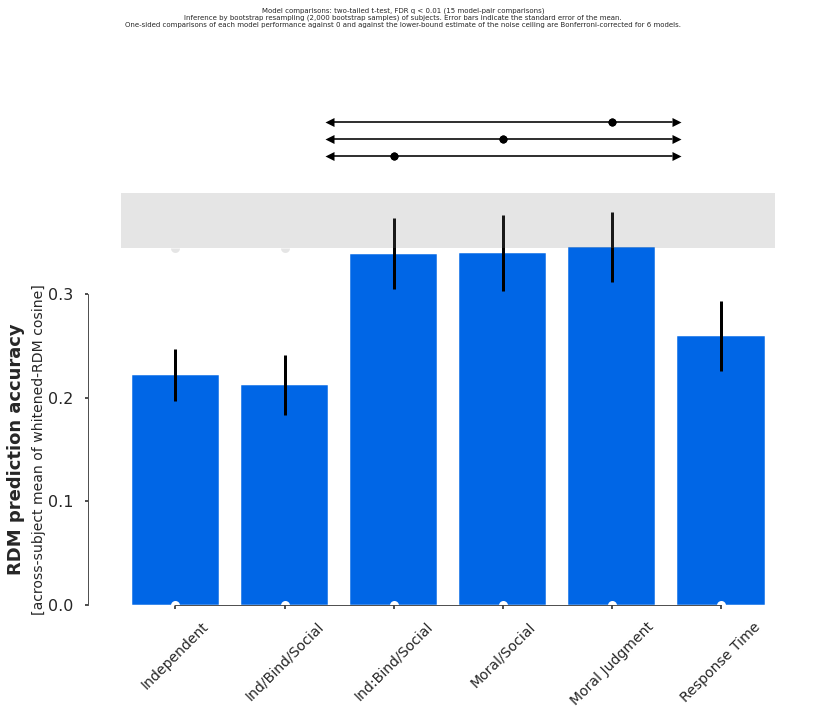

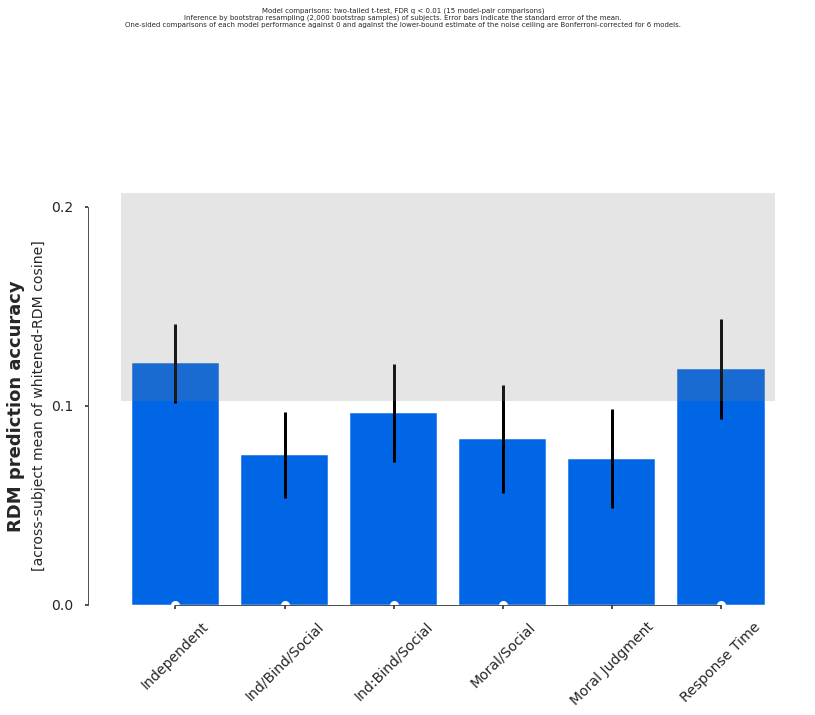

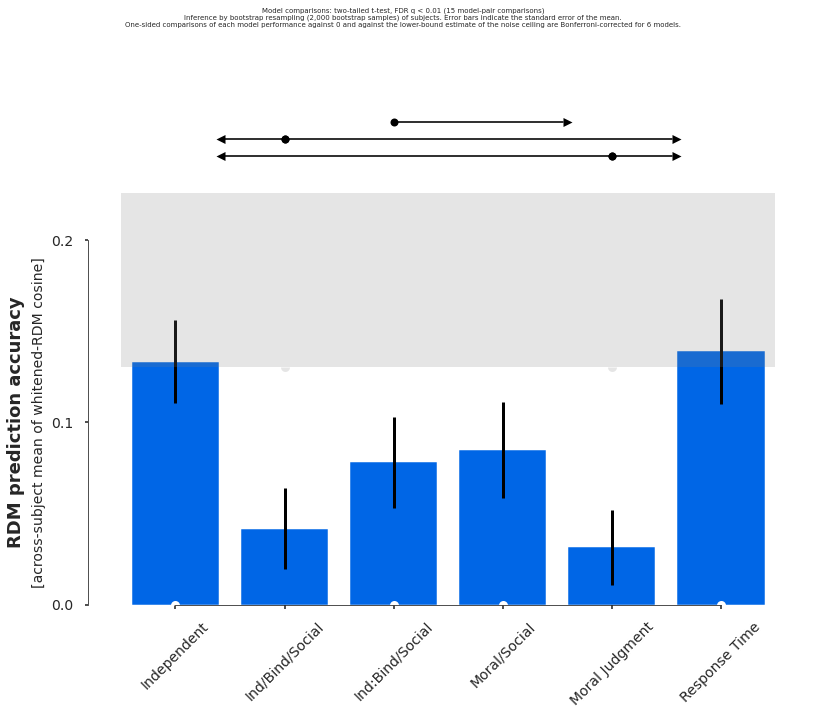

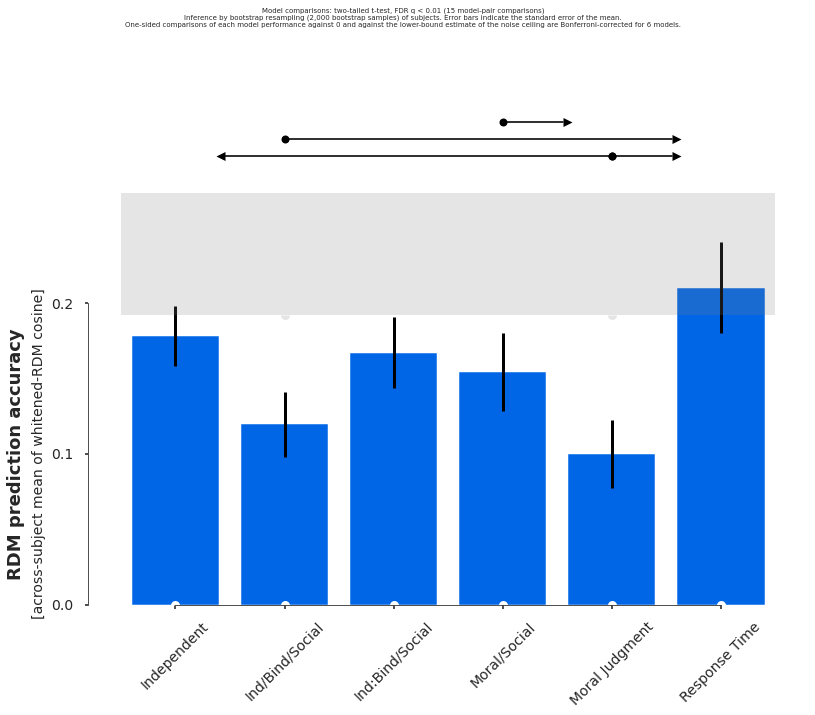

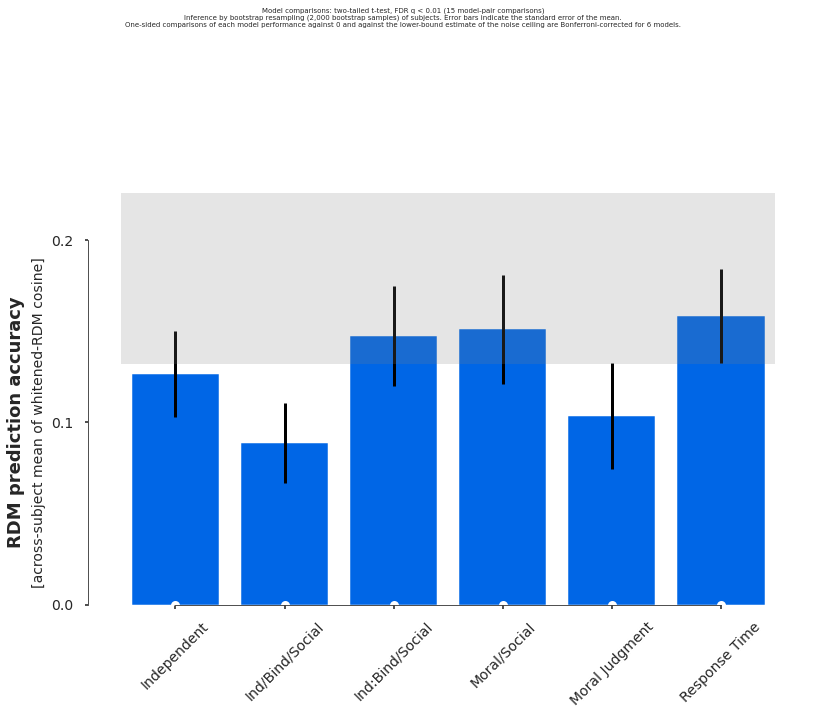

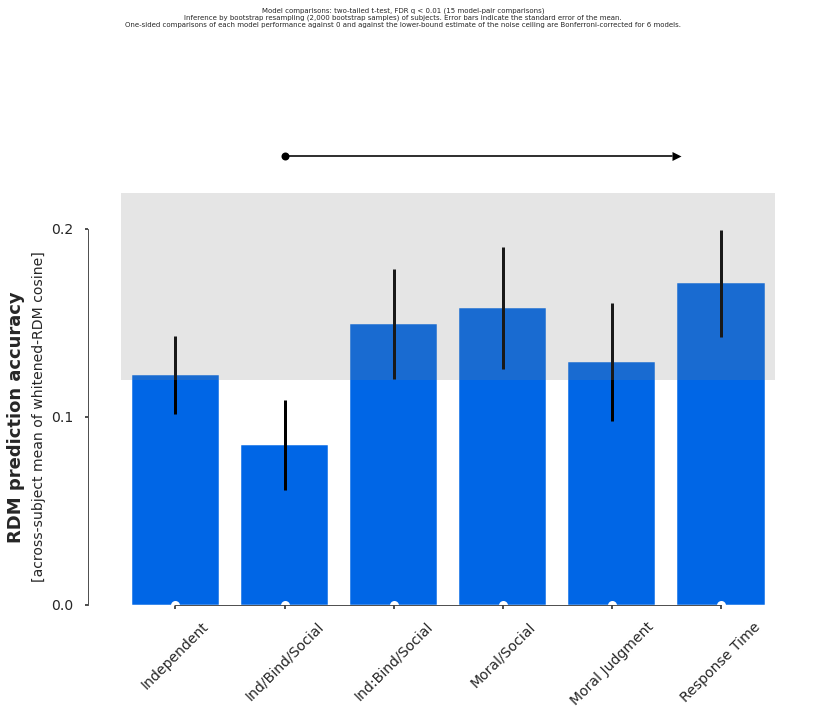

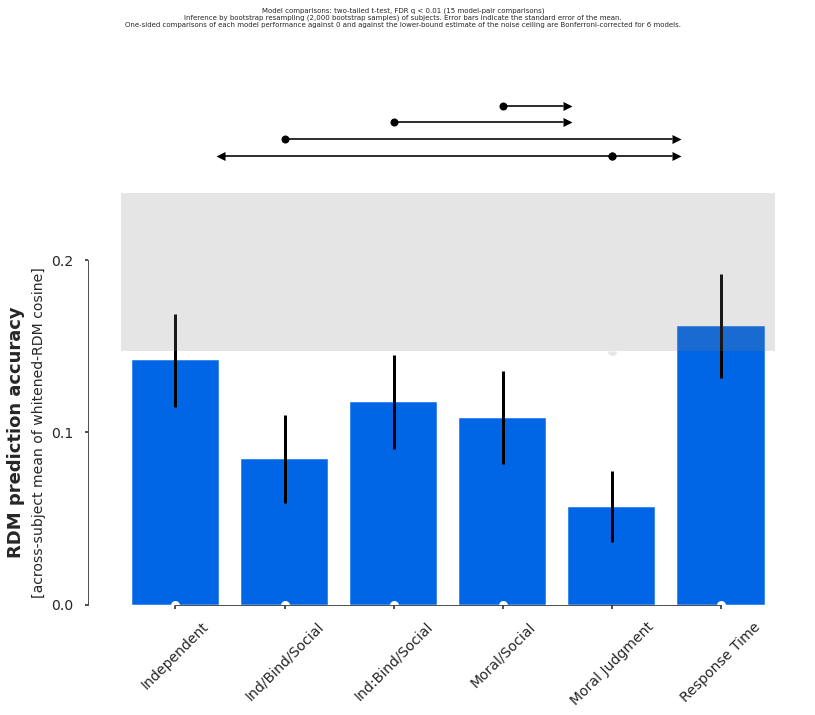

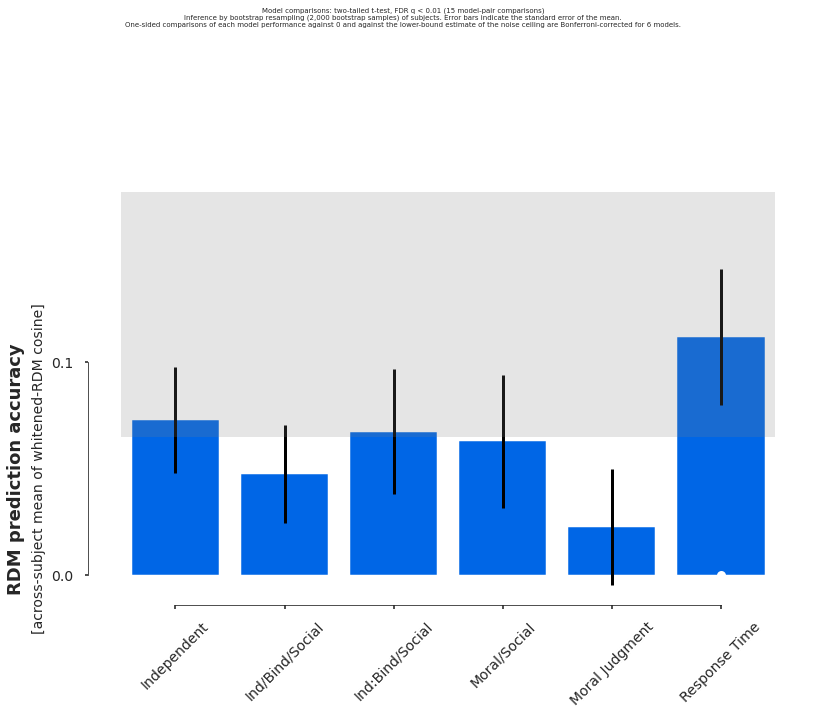

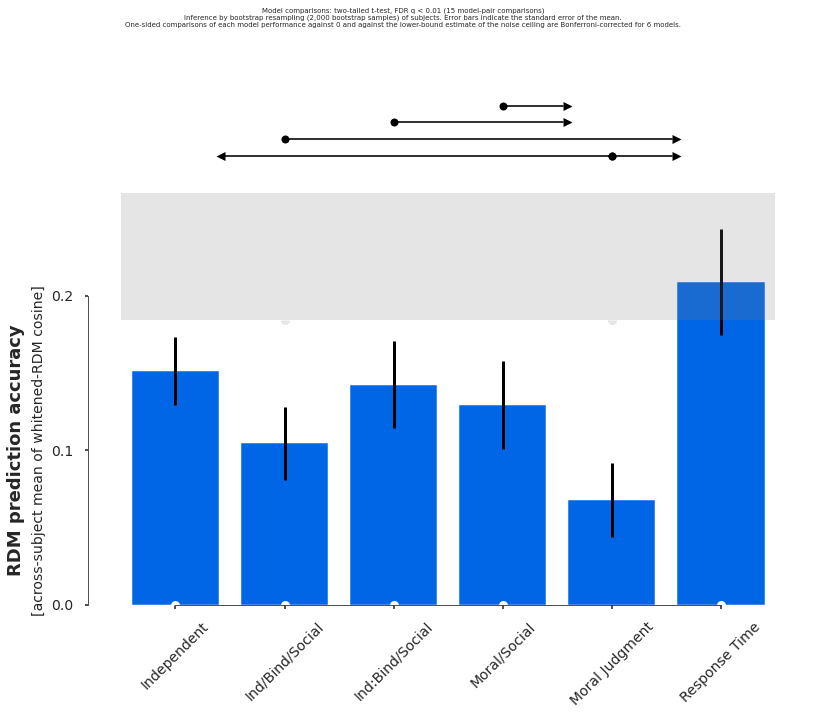

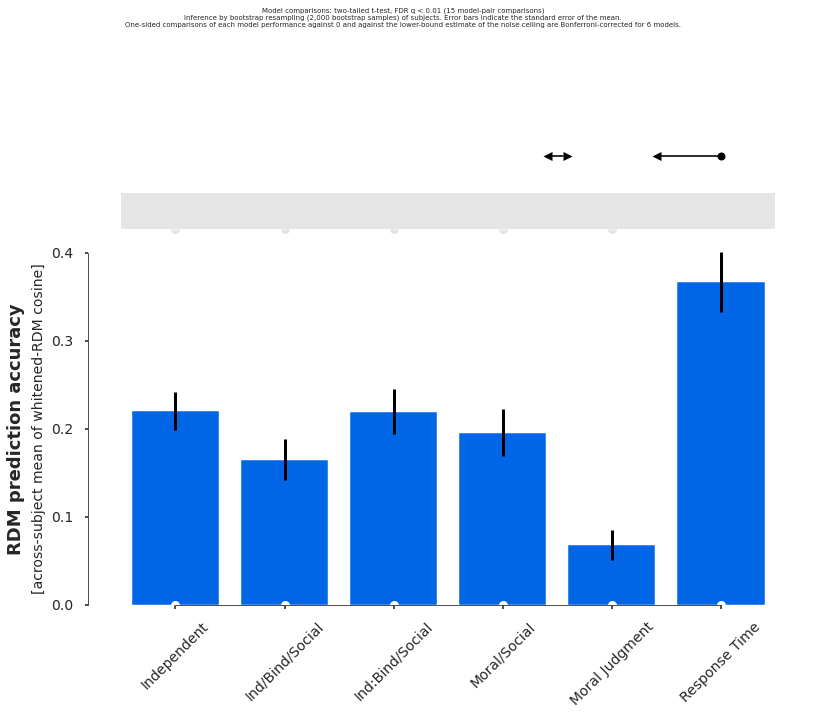

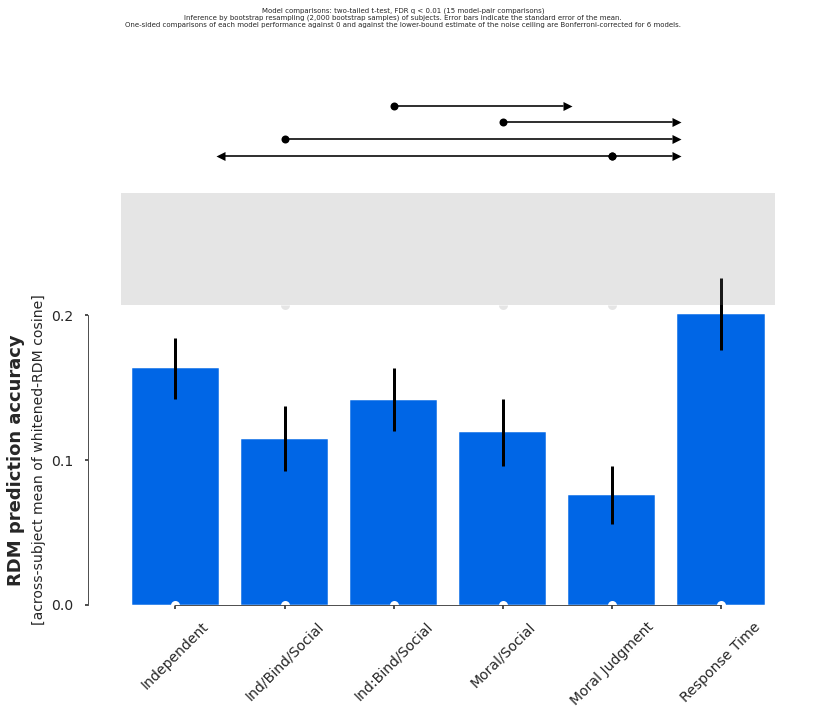

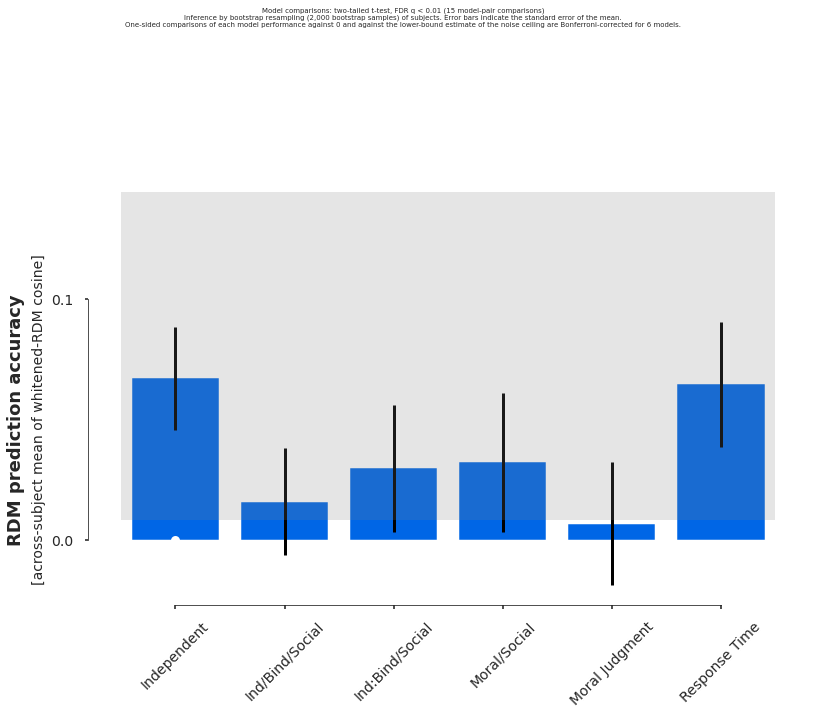

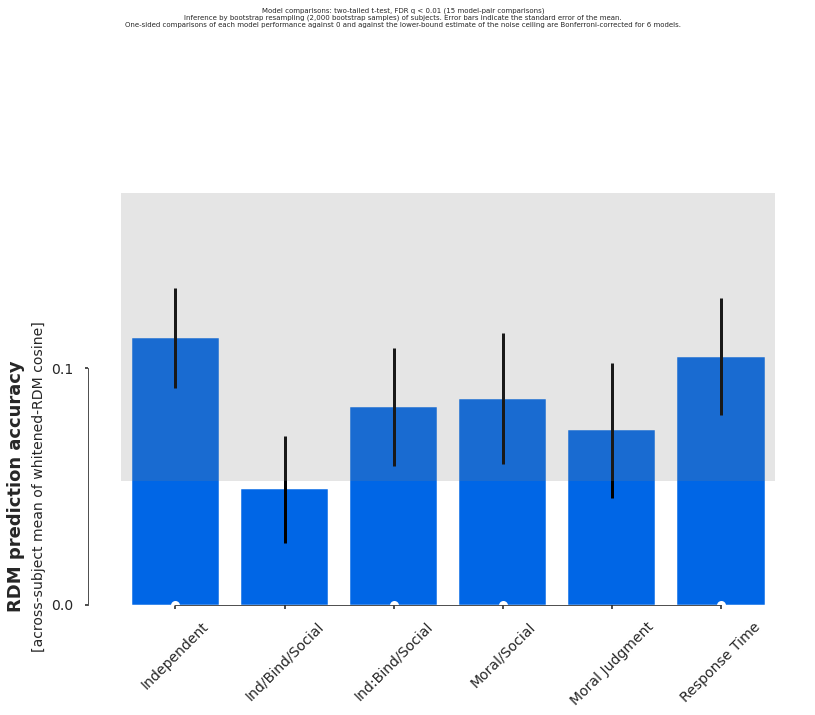

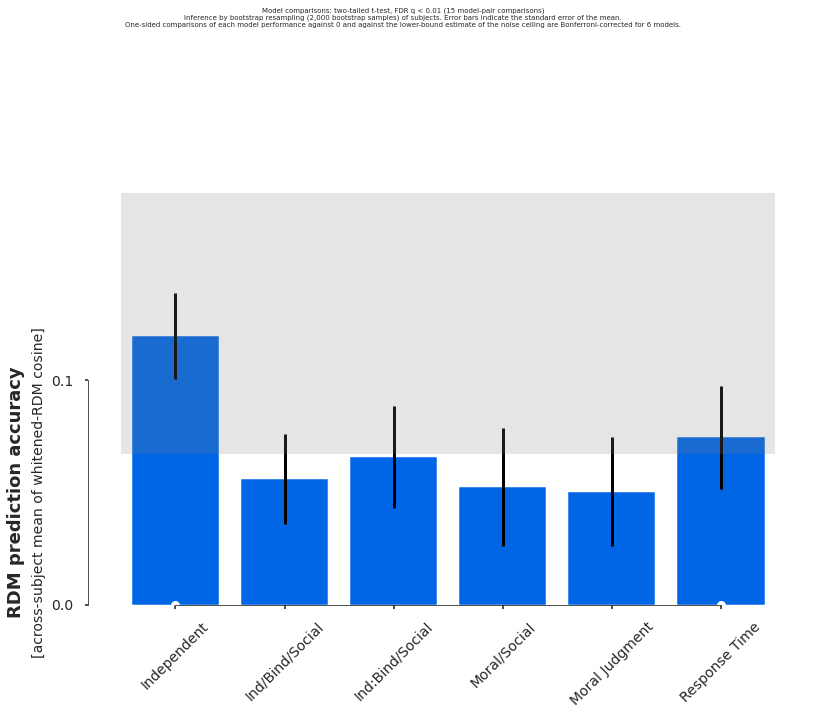

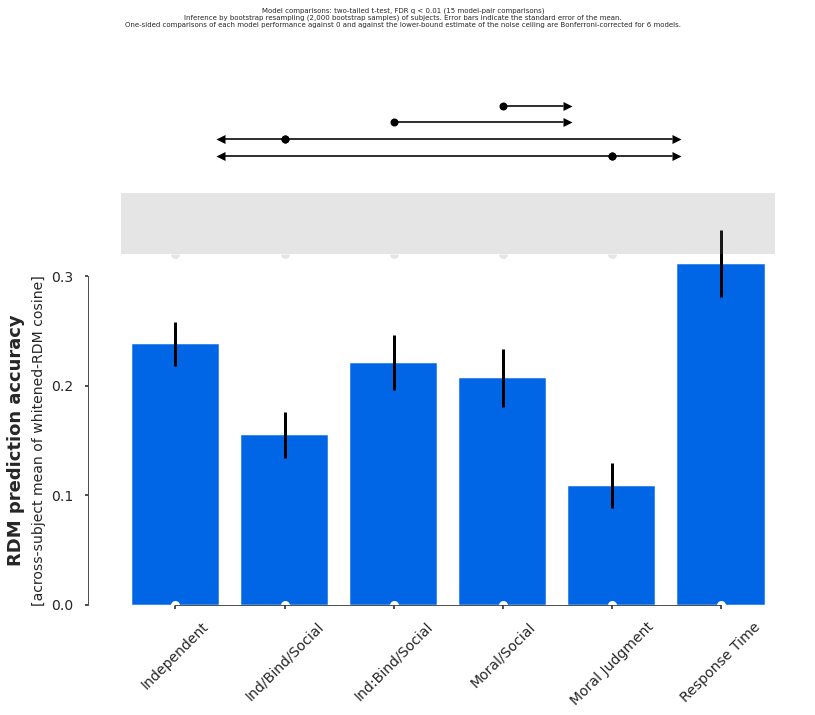

In [69]:
for (k,v) in model_comp:
    print(k)
    try:
        rsatoolbox.vis.plot_model_comparison(v)
    except:
        print('PROBLEM!')
    continue